In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
ROOT_DIR = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
import imageio
import os

images = os.listdir("/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images")
masks = os.listdir("/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks")

masks[0]

'15573_mask_48.jpg'

Text(0.5, 1.0, 'Mask')

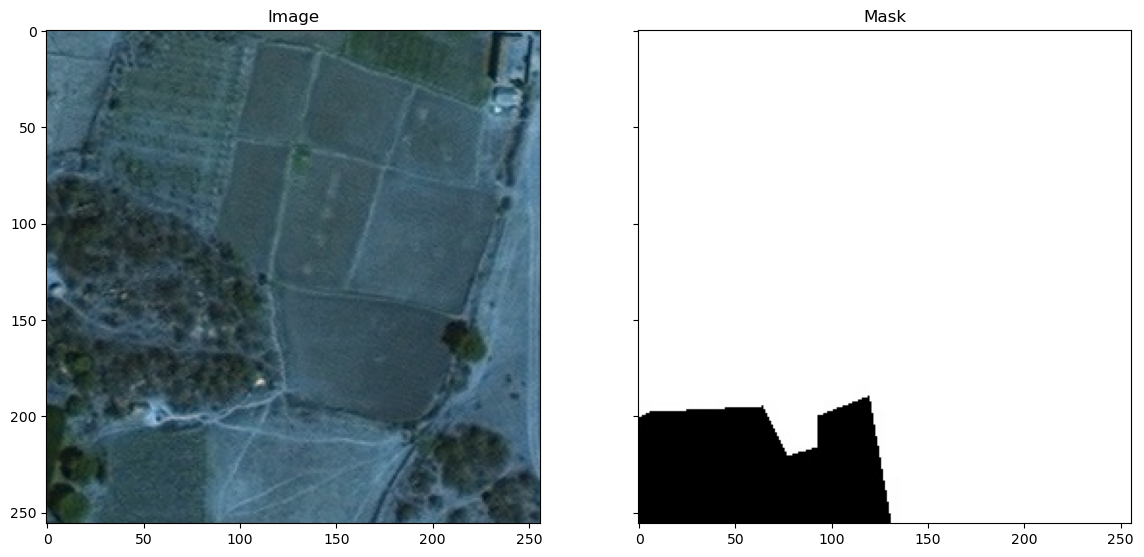

In [4]:
import cv2

_num = 103

fig, arr = plt.subplots(1, 2, sharey=True, figsize=(14,10))

image = cv2.imread(os.path.join(ROOT_DIR, "images", images[_num]))
img_arr = image.astype(np.float32)/255.0

mask = cv2.imread(os.path.join(ROOT_DIR, "masks", masks[_num]))
mask_arr = mask.astype(np.float32)/255.0

arr[0].imshow(img_arr)
arr[0].set_title("Image")
arr[1].imshow(mask_arr)
arr[1].set_title("Mask")

In [5]:
def get_image_arr(image_path, mask_path):
    image = cv2.imread(image_path)
    img_arr = image.astype(np.float32)/255.0
    
    mask = cv2.imread(mask_path)
    mask_arr = mask.astype(np.float32)/255.0
    return image, mask

In [6]:
def conv_block(inputs=None, filters=32, dropout=0, max_pooling=True):
    
    conv = tf.keras.layers.Conv2D(filters, kernel_size=3, 
                                  activation="relu", padding="same", 
                                  kernel_initializer="he_normal")(inputs)
    conv = tf.keras.layers.Conv2D(filters, kernel_size=3, 
                                  activation="relu", padding="same", 
                                  kernel_initializer="he_normal")(conv)
    
    if dropout > 0:
        conv = tf.keras.layers.Dropout(dropout)(conv)
    
    if max_pooling:
        layer_new = tf.keras.layers.MaxPooling2D()(conv)
    else:
        layer_new = conv
    
    return layer_new, conv

In [7]:
def unconv_block(iterative_input, skip_input, filters=32):
    
    unconv = tf.keras.layers.Conv2DTranspose(filters, 3, strides=(2,2), 
                                             padding="same")(iterative_input)
    merged = tf.keras.layers.concatenate([unconv, skip_input], axis=3)
    
    conv = tf.keras.layers.Conv2D(filters, kernel_size=3, 
                                  activation="relu", padding="same", 
                                  kernel_initializer="he_normal")(merged)
    conv = tf.keras.layers.Conv2D(filters, kernel_size=3, 
                                  activation="relu", padding="same", 
                                  kernel_initializer="he_normal")(conv)
    return conv

In [25]:
def train_test_split(img_arr, mask_arr, train_size=0.8):
    split_point = int(train_size*len(img_arr))
    image_train = img_arr[:split_point]
    image_test = img_arr[split_point:]
    mask_train = mask_arr[:split_point]
    mask_test = mask_arr[split_point:]
    return image_train, image_test, mask_train, mask_test

In [9]:
import tensorflow.keras.layers as tfl

def unet_model(input_size=(256, 256, 3), depth=5, filters=32, classes=2):
    
    
    inputs = tfl.Input(input_size)
    current_layer = [inputs]
    step_layers = []
    for i in range(depth):
        dropout_prob = 0.3 if i >= depth-3 else 0
        max_pooling = True if i < depth-1 else False
        current_layer = conv_block(inputs=current_layer[0], filters=filters* 2**(i), dropout=dropout_prob, max_pooling=max_pooling)
        step_layers.append(current_layer[1])
    
    current_layer = current_layer[0]
    for j in range(depth-1):
        current_layer = unconv_block(current_layer, step_layers[depth- 2 - j],filters=(filters * 2 **(depth-j-2)))

    
    current_layer = tfl.Conv2D(filters, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(current_layer)
    
    final = tfl.Conv2D(classes, kernel_size=1, padding="same")(current_layer)
    
    model= tf.keras.Model(inputs=inputs, outputs=final)
    
    return model

In [10]:
# def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
#     """
#     Unet model
    
#     Arguments:
#         input_size -- Input shape 
#         n_filters -- Number of filters for the convolutional layers
#         n_classes -- Number of output classes
#     Returns: 
#         model -- tf.keras.Model
#     """
#     inputs = tfl.Input(input_size)
#     # Contracting Path (encoding)
#     # Add a conv_block with the inputs of the unet_ model and n_filters
#     ### START CODE HERE
#     cblock1 = conv_block(inputs=inputs, filters=n_filters*1)
#     # Chain the first element of the output of each block to be the input of the next conv_block. 
#     # Double the number of filters at each new step
#     cblock2 = conv_block(inputs=cblock1[0], filters=n_filters*2)
#     cblock3 = conv_block(inputs=cblock2[0], filters=n_filters*4)
#     # Include a dropout of 0.3 for this layer
#     cblock4 = conv_block(inputs=cblock3[0], filters=n_filters*8,dropout=0.3)
#     # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
#     cblock5 = conv_block(inputs=cblock4[0], filters=n_filters*16,dropout=0.3, max_pooling=False) 
#     ### END CODE HERE
    
#     # Expanding Path (decoding)
#     # Add the first upsampling_block.
#     # From here,at each step, use half the number of filters of the previous block 
#     # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
#     ### START CODE HERE
#     ublock6 = unconv_block(cblock5[0], cblock4[1], n_filters*8)
#     # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
#     # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
#     ublock7 = unconv_block(ublock6, cblock3[1], n_filters*4)
#     ublock8 = unconv_block(ublock7, cblock2[1], n_filters*2)
#     ublock9 = unconv_block(ublock8, cblock1[1], n_filters*1)
#     ### END CODE HERE

#     conv9 = tfl.Conv2D(n_filters,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(ublock9)

#     # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
#     ### START CODE HERE
#     conv10 = tfl.Conv2D(n_classes, 1, padding='same')(conv9)
#     ### END CODE HERE
    
#     model = tf.keras.Model(inputs=inputs, outputs=conv10)

#     return model

In [11]:
img_height = 96
img_width = 128
num_channels = 3

unet_test = unet_model((img_height, img_width, num_channels))
unet_test.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [12]:
# Creating model with default params
segmentation_model = unet_model()
segmentation_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [13]:
def image_to_arr(subdir, filename):
    image = cv2.imread(os.path.join(ROOT_DIR, subdir, filename))
    img_arr = image.astype(np.float32)/255.0
    return img_arr


In [14]:
dataset_img = np.array(list(map(lambda x: image_to_arr("images", x), images)))
dataset_masks = np.array(list(map(lambda x: image_to_arr("masks", x), masks)))
print(dataset_masks.shape)

(5108, 256, 256, 3)


In [15]:
def convert_to_softmax(mask_ds):
    _shape = mask_ds.shape
    ds_new = np.sum(mask_ds, axis=-1)
    ds_alpha = np.stack((ds_new == 0, ds_new>0), axis=-1).astype(int)
    return ds_alpha

In [16]:
test_alpha = convert_to_softmax(dataset_masks)
print(test_alpha.shape)

# plt.show()
# plt.imshow(dataset_masks[0])

(5108, 256, 256, 2)


In [26]:
image_train, image_test, mask_train, mask_test = train_test_split(dataset_img, test_alpha)

In [33]:
BATCH_SIZE = 32
BUFFER_SIZE = 500

img_train_tf = tf.data.Dataset.from_tensor_slices(image_train)
mask_train_tf = tf.data.Dataset.from_tensor_slices(mask_train)

training_data = tf.data.Dataset.zip((img_train_tf, mask_train_tf))

batched_data = training_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [34]:
batched_data.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 2), dtype=tf.int64, name=None))

In [ ]:
EPOCHS = 5
# train_dataset.batch(BATCH_SIZE)
# train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

history = segmentation_model.fit(batched_data, epochs=EPOCHS)